63f78014766fd30436c18a79_Hyperspace - navbar logo.png

# Application Semantic Search Using Hyperspace

This notebook demonstrates the use of Hyperspace to perform hybrid search over an App database.
In addition to hybrid search, the notebook includes examples for classic search and vector search, based on embedding of a user provided query.

The relevent score functions can be downloaded from [Hyperspace git](https://github.com/hyper-space-io/QuickStart/blob/main/DataSets/AdVec/classic_score.py).
For more info, see the [Hyperspace documentation](https://docs.hyper-space.io/hyperspace-docs/getting-started/overview).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hyper-space-io/QuickStart/blob/master/DataSets/AdVec/advec_demo.ipynb)
# The Dataset
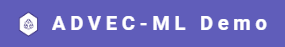

The dataset includes 89330 documents with the following fields:
1. **id** [float] - unique identifier per application
2. **title** [Keyword] - Application name
3. **bundle_id** [keyword] - identifier of the App bundle, if such exists
4. **ios** [boolean] - Is the App an IOS App (True) or Android (False)
5. **categories** [list[keyword]] - list of categories to which the App belongs
6. **content** [Keyword] - app description as text
7. **embedded_app** [list[float]] - text embedding of the app description. Text was embedded using the  Hugging face [bge-small-en model](https://huggingface.co/BAAI/bge-small-en)

The data was taken from [AdVec ML](https://demo.advecml.com/) and the search engine was built in collabortation with [Argmax.io](https://www.linkedin.com/company/argmax/?originalSubdomain=il).
The data can be downloaded from the following links: [vectors](http://hyperspace-datasets.s3.amazonaws.com/vectors.npy)
, [metadata](http://hyperspace-datasets.s3.amazonaws.com/context.jsonl)

# Hybrid search with Hyperspace
This notebook combines brute-force KNN (accurate) with metadata filtering. In this scheme, Hyperspace uses the pre-filtering approach, by which the metadata is first filtered, and KNN is applied only to vectors that pass the initial filtering. With KNN, this approach optimizes the query latency without reducing its recall.

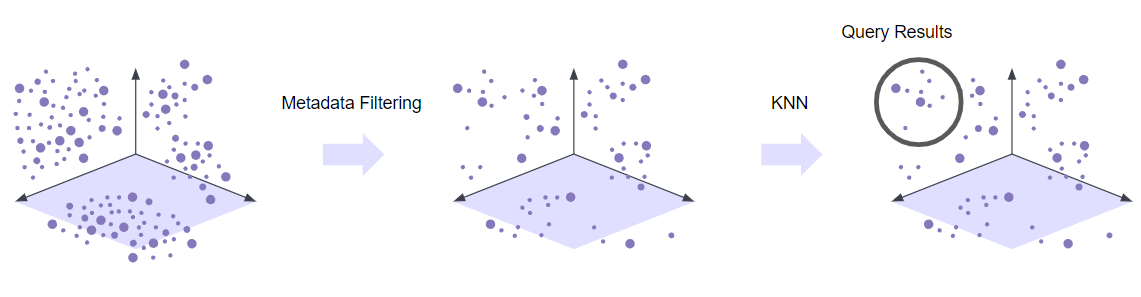


# Setting up the Hyperspace environment
Working with Hyperspace requires the followin steps

1. Install the client API
2. Create data config file
3. Connect to a server
4. Create collection
5. Ingest data
6. Run query

## 1. Install the client API
You can install the Hyperspace API directly from Git by executing the following command:

In [ ]:
pip install git+https://github.com/hyper-space-io/hyperspace-py

### Download dataset

In [ ]:
from urllib.request import urlretrieve
import os

def download_data(url, file_name):
    """
    url (str): URL of the file to download.
    file_name (str): Local path where the file will be saved.
    """
    # Check if the file already exists and is not empty
    if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
        print(f"The file {file_name} already exists and is not empty.")
    else:
        try:
            # Attempt to download the file from `url` and save it locally under `file_name`
            urlretrieve(url, file_name)
            # Check if the file was downloaded and is not empty
            if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
                print(f"Successfully downloaded {file_name}")
            else:
                print("Download failed or file is empty.")
                
        except Exception as e:
            print(f"An error occurred: {e}")


In [ ]:
metadata_url = "http://hyperspace-datasets.s3.amazonaws.com/context.jsonl"
vectors_url = "http://hyperspace-datasets.s3.amazonaws.com/vectors.npy"
download_data(metadata_url, "./context.jsonl")
download_data(vectors_url, "./vectors.npy")

## 2. Connect to a server

Once the Hyperspace API is installed, you can access database by creating a local instance of the Hyperspace client. This step requires host address, username and password, provided by Hyperspace

In [ ]:
import hyperspace
from getpass import getpass

username = "USERNAME"
host = "HOST_URL"

hyperspace_client = hyperspace.HyperspaceClientApi(host=host, username=username, password=getpass())


## 3.   Create a Data Schema File

As other search databases, Hyper-Space database requires a configuration file that outlines the data schema. Attached below is a config file that corresponds to the fields of the given dataset.

For vector fields, we also provide the index type to be used, and the metric. . Current options for index include "**brute_force**", "**hnsw**", "**ivf**", and "**bin_ivf**" for binary vectors, and "**IP**" ([inner product](https://en.wikipedia.org/wiki/Inner_product_space)) as a metric for floating point vectors and "**Hamming**" ([hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)) for binary vectors.
Here, we use "brute_force" (exact KNN) with inner product.

In [ ]:
import json

config = {
    "configuration": {
        "id": {
          "type": "keyword",
          "id": True
        },
        "title":{
        "type":"keyword"
        },
        "bundle_id": {
            "type":"keyword"
        },
        "ios":{
        "type":"boolean"
        },
        "categories": {
            "type":"keyword",
            "struct_type":"list"
        },
        "content": {
            "type":"keyword"
        },
        "embedded_app": {
            "type": "dense_vector",
            "dim": 384,
            "index_type": "brute_force",
            "metric": "IP"
        }
    }
}

with open('advec_config.json', 'w') as f:
    f.write(json.dumps(config, indent=2))

## 4. Create Collection
The Hyerspace engine stroes data in Collections, where each collecction commonly hosts data of similar context, etc. Each search is then perfomed within a collection. We create a collection using the command "**create_collection**(schema_filename, collection_name)".

In [ ]:
collection_name = 'advec'
if collection_name not in hyperspace_client.collections_info()["collections"]:
    hyperspace_client.create_collection('advec_config.json', collection_name)

hyperspace_client.collections_info()

# 5. Ingest Data

In the next step, we ingest the dataset in batches. The number documents in each batch can be controlled by the user, and specifically, it can be increased to reduce ingestion time.
Batches of data are added using the add_batch(batch, collection_name) command

In [ ]:
import numpy as np
vectors_path = "vectors.npy"
data_file_path = "context.jsonl"
vecs = np.load(vectors_path)
with open(data_file_path, encoding='cp437') as metadata_file:
    metadata= [json.loads(row) for row in metadata_file]


In [ ]:

BATCH_SIZE = 500

batch = []
for i, (metadata_row, vec) in enumerate(zip(metadata, vecs)):
    row = {key: value for key, value in metadata_row.items() if key in config["configuration"].keys()}
    row['embedded_app'] = np.ndarray.tolist(vec)
    row["id"] = str(i)
    batch.append(row)

    if i % BATCH_SIZE == 0:
        response = hyperspace_client.add_batch(batch, collection_name)
        batch.clear()
        print(i, response)
response = hyperspace_client.add_batch(batch, collection_name)
batch.clear()
print(i, response)
hyperspace_client.commit(collection_name)

In [ ]:
hyperspace_client.collections_info()

# 6. Define Logic and Run a Query
In the last step we build a Hyperspace hybrid search query. We randomly select an App from the database and search for similar applications. The overall score is defined by the weights, provided under the "boost" fields. These weights allow to contorl the relative weights of the classic search and vector search scores.

In [ ]:
input_document = hyperspace_client.get_document(collection_name, 42)
print(input_document)

## Vector Search

Let us first perform a vector search over the embedded description. This step does not require a score function

In [ ]:
results = hyperspace_client.search({'params': input_document,
                                    'knn' : [{'field': 'embedded_app',"boost": 0},
                                                {'field': 'query',"boost": 1}]},
                                        size=10,
                                        collection_name=collection_name)

for i,result in enumerate(results['similarity']):
    vector_api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    response = f"{i+1} - {result['document_id']} : {result['score']} --- "
    keys_str = " - ".join([str(vector_api_response[k]) for k in ["title","bundle_id","categories"]])
    print(response+keys_str)

## Classic Search
We repeat the process with classic search, using pre-defined score function, that can be downloaded from [Hyperspace git](https://github.com/hyper-space-io/QuickStart/blob/main/DataSets/AdVec/classic_score.py)

In [ ]:
import inspect

def set_score_function(func, collection_name, score_function_name='func'):
    source = inspect.getsource(func)
    with open('sf.py', 'w') as f:
        f.write(source)
    return hyperspace_client.set_function('sf.py', collection_name, score_function_name)
    

In [ ]:
def ios_score(params, doc):
    if match("bundle_id"):
        return 0.0

    score = 0.0
    if match("categories"):
        score += rarity_sum("categories")

    if doc["ios"]:
        score *= 2

    return score

print(set_score_function(ios_score, collection_name, score_function_name="ios_score"))

In [ ]:
query_with_knn = {
    'params': input_document,
    'knn' : [{'field': 'embedded_app',"boost": 0},
             {'field': 'query',"boost": 1}]
}

results = hyperspace_client.search(query_with_knn,
                                    size=10,
                                   function_name="ios_score",
                                        collection_name=collection_name)

for i,result in enumerate(results['similarity']):
    vector_api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    response = f"{i+1} - {result['document_id']} : {result['score']} --- "
    keys_str = " - ".join([str(vector_api_response[k]) for k in ["title","bundle_id","categories"]])
    print(response+keys_str)

## Embed User Query and Search
Let us now create a free text query, embed it using the [bge-small-en model](https://huggingface.co/BAAI/bge-small-en) and retrieve relevant apps

In [ ]:
try:
    import sentence_transformers
except ImportError:
    !pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
embbeding_model = SentenceTransformer('BAAI/bge-small-en')

In [ ]:
sim_sentence = """a great app for gaming with my friends """
sim_embedding = embbeding_model.encode([sim_sentence], normalize_embeddings=True)[0]

results = hyperspace_client.search({'params': {'embedded_app': sim_embedding.tolist()},
                                    'knn' : [{'field': 'embedded_app',"boost": 0},
                                             {'field': 'query',"boost": 1}]},
                                        size=10,
                                        collection_name=collection_name)

for i,result in enumerate(results['similarity']):
    vector_api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    response = f"{i+1} - {result['document_id']} : {result['score']} --- "
    keys_str = " - ".join([str(vector_api_response[k]) for k in ["title","bundle_id","categories"]])
    print(response+keys_str)

## Hybrid Search
In the last step, we perform a hybrid search that combines KNN using the embedded app description with a classic score function.

In [ ]:
input_document = hyperspace_client.get_document(collection_name, 7960)
input_document['title'] + "\n" + str(input_document['categories'])

In [ ]:
results = hyperspace_client.search({'params': input_document},
                                        size=10,
                                        function_name="ios_score",
                                        collection_name=collection_name)

for i,result in enumerate(results['similarity']):
    vector_api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    response = f"{i+1} - {result['document_id']} : {result['score']} --- "
    keys_str = " - ".join([str(vector_api_response[k]) for k in ["title","bundle_id","categories"]])
    print(response+keys_str)

This notebook demonstrated the use of Hyper search for classic, vector and hybrid search. For more info, visit us at [Hyper-space.io](https://www.hyper-space.io/)